In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
import itertools
from sklearn.model_selection import KFold

In [4]:
import sys
sys.path.append('../..')
from loaders import load_sabes, load_peanut
from utils import apply_df_filters, calc_loadings
from dca_research.kca import KalmanComponentsAnalysis as KCA

In [5]:
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from dca.dca import DynamicalComponentsAnalysis as DCA
from dca.cov_util import calc_pi_from_data, calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats

In [6]:
from decoders import lr_decoder

### Consolidation

In [8]:
sabes_decoding_files = glob.glob('/mnt/Secondary/data/cosyne_results/sabes_decoding/sabes_decoding_*.dat')
sabes_kca_files = glob.glob('/mnt/Secondary/data/cosyne_results/sabes_kca/sabes_kca_*.dat')
peanut_decoding_files = glob.glob('/mnt/Secondary/data/cosyne_results/peanut_decoding/peanut_decoding_*.dat')
peanut_kca_files = glob.glob('/mnt/Secondary/data/cosyne_results/peanut_kca/peanut_kca_*.dat')                            

In [10]:
results_list = []
for decoding_file in sabes_decoding_files:
    with open(decoding_file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
sabes_decoding_df = pd.DataFrame(results_list)

In [11]:
results_list = []
for file in sabes_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
sabes_kca_df = pd.DataFrame(results_list)

In [12]:
results_list = []
for file in peanut_kca_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
peanut_kca_df = pd.DataFrame(results_list)

In [13]:
results_list = []
for file in peanut_decoding_files:
    with open(file, 'rb') as f:
        result_ = pickle.load(f)
    results_list.extend(result_)
peanut_decoding_df = pd.DataFrame(results_list)

In [16]:
with open('/home/akumar/nse/neural_control/data/sabes_kca_df.dat', 'wb') as f:
    f.write(pickle.dumps(sabes_kca_df))
with open('/home/akumar/nse/neural_control/data/sabes_kca_decodign_df.dat', 'wb') as f:
    f.write(pickle.dumps(sabes_decoding_df))

dim                                                               39
fold_idx                                                           4
train_idxs         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
test_idxs          [39194, 39195, 39196, 39197, 39198, 39199, 392...
KCA                {'coef': [[-0.10390076494239872, 0.05517239556...
fit_all                                                        False
bin_width                                                         50
filter_fn                                                       none
filter_kwargs                                                     {}
boxcox                                                           0.5
spike_threshold                                                  100
dim_vals           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
n_folds                                                            5
T                                                                  5
ols_order                         

In [18]:
sabes_kca_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'KCA', 'fit_all',
       'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox', 'spike_threshold',
       'dim_vals', 'n_folds', 'T', 'ols_order', 'data_file', 'PCA', 'SFA'],
      dtype='object')

### Decoding

In [54]:
data_files = np.unique(sabes_decoding_df['data_file'].values)

In [55]:
sabes_decoding_df.keys()

Index(['dim', 'fold_idx', 'dr_method', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'trainlag', 'testlag',
       'decoding_window'],
      dtype='object')

In [56]:
dim_vals = np.unique(sabes_decoding_df['dim'].values)

# data_files x dim_val x folds
sr2_pos_kca = np.zeros((len(data_files), dim_vals.size, 5))
sr2_pos_pca = np.zeros((len(data_files), dim_vals.size, 5))

sr2_vel_kca = np.zeros((len(data_files), dim_vals.size, 5))
sr2_vel_pca = np.zeros((len(data_files), dim_vals.size, 5))


for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dim_vals):
        pca_df = apply_df_filters(sabes_decoding_df, dim=dim, data_file=data_file, dr_method='PCA')
        for k in range(pca_df.shape[0]):
            sr2_pos_pca[i, j, k] = pca_df.iloc[k]['r2'][0]
            sr2_vel_pca[i, j, k] = pca_df.iloc[k]['r2'][1]
        
        kca_df = apply_df_filters(sabes_decoding_df, dim=dim, data_file=data_file, dr_method='KCA')
        for k in range(pca_df.shape[0]):
            sr2_pos_kca[i, j, k] = kca_df.iloc[k]['r2'][0]
            sr2_vel_kca[i, j, k] = kca_df.iloc[k]['r2'][1]
            


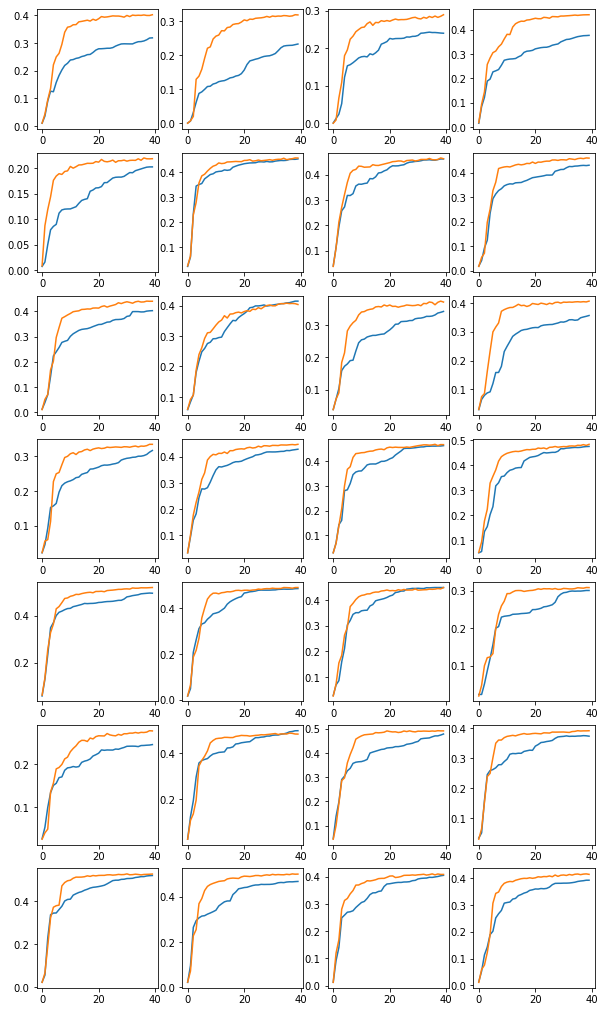

In [58]:
# Plot across data files
fig, ax = plt.subplots(7, 4, figsize=(10, 18))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    a.plot(np.mean(sr2_pos_pca[i], axis=1))
    a.plot(np.mean(sr2_pos_kca[i], axis=1))

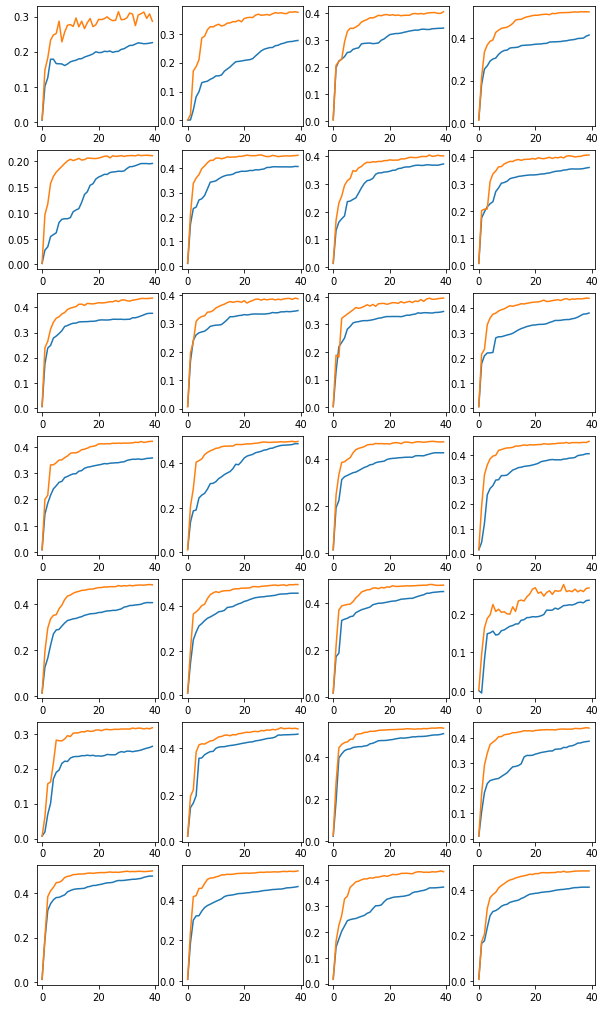

In [45]:
# Plot across data files
fig, ax = plt.subplots(7, 4, figsize=(10, 18))

for i in range(len(data_files)):
    a = ax[np.unravel_index(i, (7, 4))]
    a.plot(np.mean(sr2_vel_pca[i], axis=1))
    a.plot(np.mean(sr2_vel_kca[i], axis=1))

In [59]:
peanut_decoding_df.keys()

Index(['dim', 'fold_idx', 'dr_method', 'decoder', 'decoder_args',
       'decoder_obj', 'r2', 'data_file', 'bin_width', 'epoch', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'speed_threshold',
       'trainlag', 'testlag', 'decoding_window'],
      dtype='object')

In [61]:
epochs = np.unique(peanut_decoding_df['epoch'].values)

In [62]:
dim_vals = np.unique(peanut_decoding_df['dim'].values)

# epochs x dim_val x folds
pr2_pos_kca = np.zeros((len(epochs), dim_vals.size, 5))
pr2_pos_pca = np.zeros((len(epochs), dim_vals.size, 5))

pr2_vel_kca = np.zeros((len(epochs), dim_vals.size, 5))
pr2_vel_pca = np.zeros((len(epochs), dim_vals.size, 5))

for i, epoch in enumerate(epochs):
    for j, dim in enumerate(dim_vals):
        pca_df = apply_df_filters(peanut_decoding_df, dim=dim, epoch=epoch, dr_method='PCA')
        for k in range(pca_df.shape[0]):
            pr2_pos_pca[i, j, k] = pca_df.iloc[k]['r2'][0]
            pr2_vel_pca[i, j, k] = pca_df.iloc[k]['r2'][1]
        
        kca_df = apply_df_filters(peanut_decoding_df, dim=dim, epoch=epoch, dr_method='KCA')
        for k in range(pca_df.shape[0]):
            pr2_pos_kca[i, j, k] = kca_df.iloc[k]['r2'][0]
            pr2_vel_kca[i, j, k] = kca_df.iloc[k]['r2'][1]
            


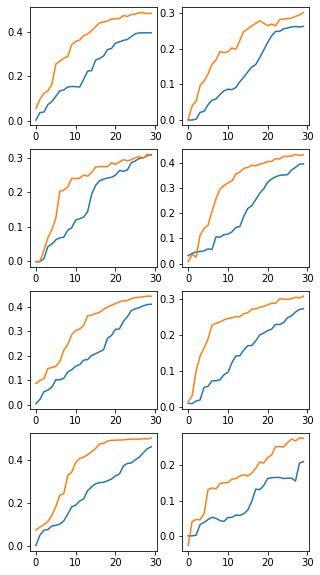

In [63]:
# Plot across data files
fig, ax = plt.subplots(4, 2, figsize=(5, 10))

for i in range(len(epochs)):
    a = ax[np.unravel_index(i, (4, 2))]
    a.plot(np.mean(pr2_vel_pca[i], axis=1))
    a.plot(np.mean(pr2_vel_kca[i], axis=1))

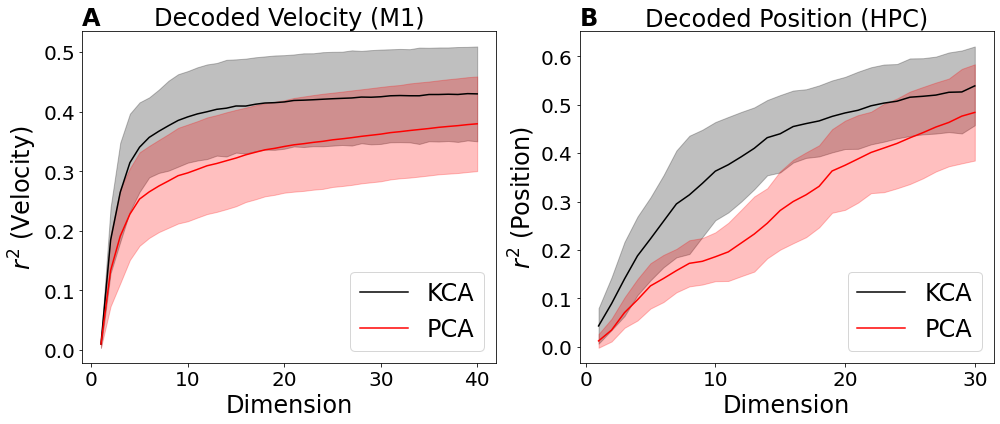

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

labels = ['KCA', 'PCA']
        
# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red']

dim_vals = np.unique(sabes_decoding_df['dim'].values)
for i, r2_ in enumerate([sr2_vel_kca, sr2_vel_pca]): 
    # Average across folds
    r2_ = np.nanmean(r2_, axis=2)
    r2_mean = np.nanmean(r2_, axis=0)
    r2_std = np.std(r2_, axis=0)
    ax[0].plot(dim_vals, r2_mean, label=labels[i], color=colors[i])
    ax[0].fill_between(dim_vals, r2_mean - r2_std, r2_mean + r2_std, alpha=0.25, 
                 color=colors[i])

dim_vals = np.unique(peanut_decoding_df['dim'].values)    
for i, r2_ in enumerate([pr2_pos_kca, pr2_pos_pca]): 
    r2_ = np.nanmean(r2_, axis=2)
    r2_mean = np.nanmean(r2_, axis=0)
    r2_std = np.std(r2_, axis=0)
    
    ax[1].plot(dim_vals, r2_mean, label=labels[i], color=colors[i])
    ax[1].fill_between(dim_vals, r2_mean - r2_std, r2_mean + r2_std, alpha=0.25, 
                    color=colors[i])

ax[0].legend(loc='lower right', fontsize=24)
ax[1].legend(loc='lower right', fontsize=24)
ax[0].set_xlabel('Dimension', fontsize=24)
ax[1].set_xlabel('Dimension', fontsize=24)


ax[0].set_ylabel(r'$r^2$ (Velocity)', fontsize=24)
ax[1].set_ylabel(r'$r^2$ (Position)', fontsize=24)

ax[0].set_title('Decoded Velocity (M1)', fontsize=24)
ax[1].set_title('Decoded Position (HPC)', fontsize=24)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)


ax[0].text(0.0, 1.075, 'A', transform=ax[0].transAxes,
          fontsize=24, fontweight='bold', va='top')    
ax[1].text(0.0, 1.075, 'B', transform=ax[1].transAxes,
          fontsize=24, fontweight='bold', va='top')    
fig.tight_layout()
fig.savefig('decoding_averaged.pdf', bbox_inches='tight', pad_inches=0)

In [67]:
# Demonstrate lack of correlation between loadings and measure subspace angles

### Loadings/subspace angles

In [75]:
sabes_kca_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'KCA', 'fit_all', 'PCA',
       'SFA', 'bin_width', 'filter_fn', 'filter_kwargs', 'boxcox',
       'spike_threshold', 'dim_vals', 'n_folds', 'T', 'ols_order',
       'data_file'],
      dtype='object')

In [90]:
peanut_kca_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'KCA', 'fit_all',
       'bin_width', 'epoch', 'filter_fn', 'filter_kwargs', 'boxcox',
       'spike_threshold', 'speed_threshold', 'dim_vals', 'n_folds', 'T',
       'ols_order', 'data_file', 'PCA', 'SFA'],
      dtype='object')

In [112]:
kca_loadings = []
pca_loadings = []

phi = []

for i, data_file in enumerate(data_files):
    
    kca_df = apply_df_filters(sabes_kca_df, data_file=data_file, dim=2, fold_idx=0)
    kca_loadings.extend(calc_loadings(kca_df.iloc[0]['KCA']['coef']))
    
    pca_df = apply_df_filters(sabes_kca_df, data_file=data_file, fit_all=True, fold_idx=0)
    pca_loadings.extend(calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    
    phi.extend(scipy.linalg.subspace_angles(kca_df.iloc[0]['KCA']['coef'],
                                            pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    
for i, epoch in enumerate(epochs):
    
    kca_df = apply_df_filters(peanut_kca_df, epoch=epoch, dim=2, fold_idx=0)
    assert(kca_df.shape[0] == 1)
    kca_loadings.extend(calc_loadings(kca_df.iloc[0]['KCA']['coef']))

    pca_df = apply_df_filters(peanut_kca_df, epoch=epoch, fit_all=True, fold_idx=0)
    assert(pca_df.shape[0] == 1)

    pca_loadings.extend(calc_loadings(pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    phi.extend(scipy.linalg.subspace_angles(kca_df.iloc[0]['KCA']['coef'],
                                            pca_df.iloc[0]['PCA']['coef'][:, 0:2]))
    

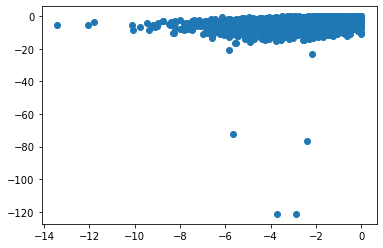

In [113]:
plt.scatter(np.log(kca_loadings), np.log(pca_loadings))

In [114]:
scipy.stats.spearmanr(kca_loadings, pca_loadings)

SpearmanrResult(correlation=0.12705970331040548, pvalue=7.492540461697585e-17)

In [121]:
from matplotlib.ticker import FormatStrFormatter

In [157]:
with open('nn_example.dat', 'rb') as f:
    sim_spearmanr = pickle.load(f)
    sim_phi = pickle.load(f)

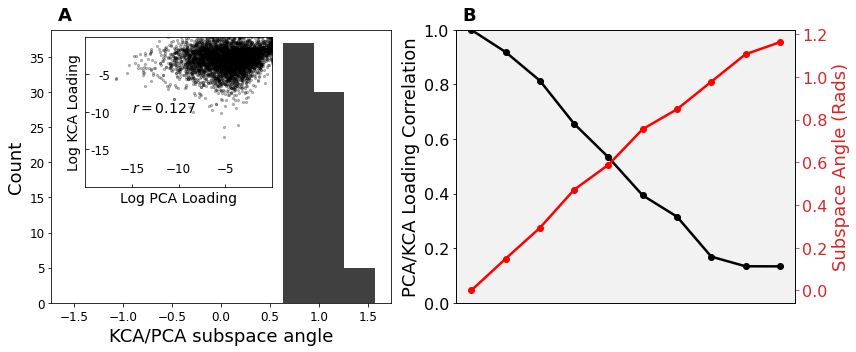

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(np.array(phi), range=(-np.pi/2, np.pi/2), bins=10, rwidth=1, color='k', alpha=0.75)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[0].set_xlabel('KCA/PCA subspace angle', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)

#ax[0].set_yticklabels([])

ax2 = ax[0].inset_axes(bounds=(0.1, 0.425, 0.55, 0.55))
ax2.scatter(np.log(pca_loadings), np.log(kca_loadings), color='k', alpha=0.25, s=5)
ax2.set_xlim([-20, 0])
ax2.set_ylim([-20, 0])
r2 = scipy.stats.spearmanr(pca_loadings, kca_loadings)[0]
ax2.text(-15, -10, r'$r=%.3f$' % r2, fontsize=14)
ax2.set_ylabel('Log KCA Loading', fontsize=14)
ax2.set_xlabel('Log PCA Loading', fontsize=14)
ax2.set_yticks([-20, -15, -10, -5, 0])
ax2.set_yticklabels([-20, -15, -10, -5, 0])
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xticks([-5, -10, -15])
ax2.set_yticks([-5, -10, -15])
ax2.tick_params(axis='both', direction='in', pad=-25)

ax[1].plot(np.mean(sim_spearmanr, axis=1), '-o', lw=2.5, color='k')
#ax[1, 0].set_ylabel(r'|Re$(\lambda)$|', fontsize=16)
#ax[1, 0].set_xticklabels([])

ax3 = ax[1].twinx()
ax3.plot(np.mean(sim_phi, axis=1),'-o', lw=2.5, color='r')

ax3.set_ylabel('Subspace Angle (Rads)', fontsize=18, color='tab:red')

ax[1].set_ylim([0, 1])
ax[1].set_facecolor('#f2f2f2')
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_ylabel('PCA/KCA Loading Correlation', fontsize=18)
ax[1].set_xticks([])
ax3.yaxis.label.set_color('tab:red')
ax3.tick_params(axis='y', which='major', labelsize=16, color='tab:red', colors='tab:red')
# Letters
ax[0].text(0.02, 1.02, 'A', transform=ax[0].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax[1].text(0.02, 1.02, 'B', transform=ax[1].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    

fig.tight_layout()
fig.savefig('loadings_ssangles.png', bbox_inches='tight', pad_inches=0, dpi=600)

In [156]:
# Move on....

In [176]:
.98 * 180/np.pi

56.14986392282068

In [175]:
np.mean(phi)

0.9755306397952257

### Single unit correlatiosn